In [130]:
import pandas as pd
import numpy as np
import json
import string
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import operator

import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D


In [81]:
df = pd.read_csv("Test/mediascale/movies.csv")
df.head()

,movie_id,year,synopsis,genres
0,30924,2005,Cruel But Necessary is the story of Betty Muns...,Drama
1,34841,2012,"Yorkshire, 1974, the Maynard family moves into...",Drama Horror Thriller
2,23408,2017,When a renowned architecture scholar falls sud...,Drama
3,39470,1996,The story dealt with Lord Rama and his retalia...,Children Drama
4,7108,2003,A Thai playboy cons a girl into bed and then l...,Comedy Drama Horror Thriller


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35488 entries, 0 to 35487
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  35488 non-null  int64 
 1   year      35488 non-null  int64 
 2   synopsis  35488 non-null  object
 3   genres    35488 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [83]:
df = df[~(df['genres'].str.len() == 0)]

In [84]:
genres = [] 

for i in df['genres']: 
  genres.append((i.split(' '))) 

df['genres'] = genres

In [85]:
all_genres = sum(genres,[])
len(set(all_genres))

19

In [86]:
all_genres = nltk.FreqDist(all_genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

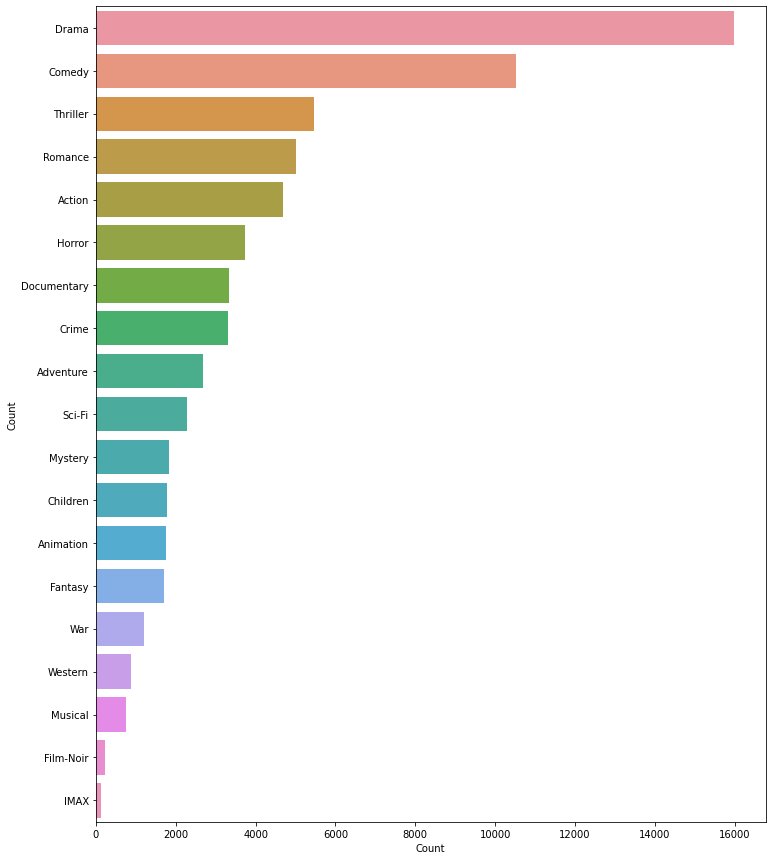

In [87]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [88]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 
stopwords_list += [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

In [89]:
df['synopsis'] = df['synopsis'].map(lambda x : clean_text(x))


In [90]:
df['synopsis']

0        cruel necessary story betty munson strange jou...
1        yorkshire maynard family moves dream house dre...
2        renowned architecture scholar falls suddenly i...
3        story dealt lord rama retaliation ravana chara...
4        thai playboy cons girl bed leaves finding preg...
                               ...                        
35483    prequel mou gaan dou chan wing yan become unde...
35484    ann husband george son georgie arrive holiday ...
35485    former sports star fallen hard times starts co...
35486    hard hitting western drama starring mitchum or...
35487    abner peacock knotts beloved bird watcher maga...
Name: synopsis, Length: 35488, dtype: object

In [91]:
df = df.drop(columns=['year'])

In [92]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])
y = multilabel_binarizer.transform(df['genres'])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df['synopsis'], y, test_size=0.2, random_state=9)

In [94]:
from sklearn.dummy import DummyClassifier
dummy_grid = {
    'estimator__strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
clf = OneVsRestClassifier(dummy)
dummy_gs = GridSearchCV(clf, param_grid = dummy_grid, cv = 5)
dummy_gs.fit(X_train, y_train)
print(dummy_gs.best_score_)

0.03039802747446284


In [95]:
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df=1.0, min_df=15, lowercase=False)
X_train = vectorizer.fit_transform(X_train)



In [96]:
df1 = pd.DataFrame(X_train[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
df1 = df1.sort_values('TF-IDF', ascending=False)
print (df1.head(25))

                TF-IDF
hamburg       0.366063
happy         0.248822
dies          0.241311
long          0.193943
confusing     0.181723
disappointed  0.179323
budding       0.169466
confesses     0.166139
affections    0.165531
inherits      0.158878
time          0.156223
studies       0.153114
eric          0.151181
loyal         0.151181
stays         0.150275
love          0.144585
spent         0.140846
musician      0.136222
visits        0.135023
ready         0.134877
farm          0.130091
meeting       0.128741
asks          0.125983
although      0.125415
loves         0.122780


In [97]:
X_test = vectorizer.transform(X_test)


In [98]:
model_resultstfidf = {}
mnb_grid = {
    'estimator__alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'estimator__fit_prior' : [True, False],
 'estimator__class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}


mnb = MultinomialNB()
clf = OneVsRestClassifier(mnb)
mnb_grid = GridSearchCV(clf, param_grid = mnb_grid, cv = 5)
mnb_grid.fit(X_train, y_train)
print(mnb_grid.best_score_)

model_resultstfidf['Multinomial Bayes'] = mnb_grid.best_score_

0.2028883409651286


# LogisticRegression

In [100]:
lr_grid = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__C' : [ 1e4, 1e10],
    'estimator__class_weight' : ['balanced', None],
    'estimator__solver' : ['lbfgs', 'liblinear'],
    'estimator__multi_class' : ['ovr', 'multinomial']
}



lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
logreg_tfidf_gs = GridSearchCV(clf, param_grid = lr_grid, cv = 5)
logreg_tfidf_gs.fit(X_train, y_train)
print(logreg_tfidf_gs.best_score_)
model_resultstfidf['Logistic Regression'] = logreg_tfidf_gs.best_score_

0.12888340965128567


In [142]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [143]:
# fit model on train data
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [144]:
y_pred = clf.predict(X_test)


In [145]:
f1_score(y_test, y_pred, average="micro")


0.44468149954282227

In [173]:
ths = np.arange(.15,.3,.001)
dicth={}
for t in ths:
    y_pred_new = (y_pred_prob >= t).astype(int)
    dicth[t] = (f1_score(y_test, y_pred_new, average="micro"))


In [174]:
max(dicth.items(), key=operator.itemgetter(1))


(0.22500000000000006, 0.5720626631853786)

In [108]:
from sklearn.metrics import accuracy_score, classification_report
print('Test Accuracy score:', accuracy_score(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))

Test Accuracy score: 0.12834601296139758
              precision    recall  f1-score   support

           0       0.50      0.61      0.55       998
           1       0.47      0.36      0.40       556
           2       0.69      0.36      0.47       355
           3       0.53      0.24      0.34       360
           4       0.46      0.85      0.60      2121
           5       0.47      0.46      0.46       674
           6       0.72      0.71      0.71       654
           7       0.52      0.95      0.67      3152
           8       0.56      0.23      0.33       327
           9       0.00      0.00      0.00        46
          10       0.63      0.63      0.63       757
          11       0.00      0.00      0.00        24
          12       0.25      0.04      0.07       136
          13       0.46      0.25      0.32       374
          14       0.43      0.54      0.48       993
          15       0.65      0.48      0.55       459
          16       0.44      0.59      0

# Decision Tree

In [111]:
grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [1, 2, 5, 10],
    'estimator__min_samples_split': [1, 5, 10, 20]
}



dt_clf = DecisionTreeClassifier (random_state = 42)
clf = OneVsRestClassifier(dt_clf)
gs_tfidf_tree = GridSearchCV(clf, param_grid = grid, cv = 5)
gs_tfidf_tree.fit(X_train, y_train)

print(gs_tfidf_tree.best_score_)
model_resultstfidf['Decision Tree'] = gs_tfidf_tree.best_score_

0.13466009158154282


# SGD

In [113]:
grid = {
    'estimator_loss' : ['hinge', 'log'],
    'estimator_penalty' : ['l2', 'l1'],
    'estimator_alpha' : [1e-3, 1e-4, 1e-5],
    'estimator_max_iter' : [20, 25, 30],
    'estimator_class_weight' : ['balanced', None]
}


sgd = SGDClassifier(random_state=42)
clf = OneVsRestClassifier(sgd)
sgd_tfidf_gs = GridSearchCV(clf, param_grid = grid, cv = 5)
sgd_tfidf_gs.fit(X_train, y_train)

print(sgd_tfidf_gs.best_score_)
model_resultstfidf['SGD'] = sgd_tfidf_gs.best_score_

0.1246213455442057


In [114]:
from sklearn.metrics import accuracy_score, classification_report
print('Test Accuracy score:', accuracy_score(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))

Test Accuracy score: 0.12834601296139758
              precision    recall  f1-score   support

           0       0.50      0.61      0.55       998
           1       0.47      0.36      0.40       556
           2       0.69      0.36      0.47       355
           3       0.53      0.24      0.34       360
           4       0.46      0.85      0.60      2121
           5       0.47      0.46      0.46       674
           6       0.72      0.71      0.71       654
           7       0.52      0.95      0.67      3152
           8       0.56      0.23      0.33       327
           9       0.00      0.00      0.00        46
          10       0.63      0.63      0.63       757
          11       0.00      0.00      0.00        24
          12       0.25      0.04      0.07       136
          13       0.46      0.25      0.32       374
          14       0.43      0.54      0.48       993
          15       0.65      0.48      0.55       459
          16       0.44      0.59      0